# Multiple Peaks Simulations

In this set of simulations, we will test FOOOF's performance across power spectra simulated multiple peaks. 

In particular, we will simulate power spectra with a varying number of peaks, each with varying parameters, and with the aperiodic component in 'fixed' mode, also across varying parameters. In these simulations we will focus on how well FOOOF performs at reconstructing the power spectra in terms of the number of fit peaks, the aperiodic parameters, and the overall model fit.

In [1]:
import pickle
from collections import Counter

import numpy as np

from fooof import FOOOFGroup, fit_fooof_group_3d
from fooof.sim import gen_group_power_spectra

In [2]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from settings import *
from utils import *
from plts import *

## Settings

In [3]:
# Set random seed
import random
random.seed(333)

In [4]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [5]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = True

### Simulate Power Spectra

In [6]:
# Set the number of PSDs - this is per n_oeak condition
n_psds = 1000

# Set the noise levels to use
n_peaks = [0, 1, 2, 3, 4]
nlv = 0.01

# Use generators to sample peak & aperiodic parameters
peaks = []
for n_peak in n_peaks:
    peaks.append(gen_peak_def(n_peak))
aps = gen_ap_def()

In [7]:
# Get data sizes
n_n_peaks = len(n_peaks)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

In [8]:
# Generate or load power spectra
data_name = 'multi_peak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    freqs = np.empty(shape=n_freqs)
    psds = np.empty(shape=[n_n_peaks, n_psds, n_freqs])
    sim_params = [None] * n_n_peaks

    # Generate simulated power spectra
    for n_ind, n_peak, peaks in zip(range(n_n_peaks), n_peaks, peaks):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv, F_RES)
        
    # Save out generated simulations & parameter definitions
    np.savez(DATA_PATH + data_name + '.npz', freqs, psds)
    with open(DATA_PATH + data_name + '.p', 'wb') as f_obj:
        pickle.dump(sim_params, f_obj)
        
else:
    
    # Load previously generated simulations & parameter definitions
    temp = np.load(data_path + data_name + '.npz')
    freqs, psds = temp['arr_0'], temp['arr_1']
    with open(data_path + data_name + '.p', 'rb') as f_obj:
        sim_params = pickle.load(f_obj)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [9]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

### Fit Power Spectra with FOOOF

In [10]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=0.1,
                aperiodic_mode='fixed', verbose=False)

# Check settings for FOOOF used to fit multiple peak simulations
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [11]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds)

### Extract FOOOF fit Data

In [12]:
# Extract data of interest from FOOOF fits
_, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

In [13]:
# Calculate error
ap_errors = np.abs(ap_truths - ap_fits)

In [14]:
# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
exp_errors = ap_errors[:, :, 1]

In [15]:
# Grab all data for number of peaks simulated
n_actual_peaks = []
for nn in n_peaks:
    n_actual_peaks.append([nn] * n_psds)
n_actual_peaks = np.array(n_actual_peaks)
n_actual_peaks = n_actual_peaks.flatten()

# Grab data for number of peaks fit
n_fit_peaks = n_fit_peaks.flatten()

# Collect together # simulated & # fit, for plotting
data = []
for aa, bb in zip(n_actual_peaks, n_fit_peaks):
    data.append((aa, bb))
n_peak_counter = Counter(data)

### Check Average Errors & Stats

In [16]:
# Check overall fit quality
temp = r2_fits.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.9255 	0.9998
Median  R^2: 	0.9990


In [17]:
# Collect data together
datas = {
    'OFF' : off_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [18]:
# Print out the average error for each parameter, across number of peaks
#   Also prints out the average model error and R^2 per peak count
for label, data in datas.items():
    print(label)
    print('\t', np.nanmedian(data, 1))

OFF
	 [0.0022643  0.00411661 0.0151018  0.03927679 0.09030891]
EXP
	 [0.00177223 0.00324144 0.00988861 0.0233708  0.05185703]
ERR
	 [0.00792837 0.00814412 0.00916423 0.01168803 0.0149889 ]
R^2
	 [0.99920374 0.99923094 0.99901439 0.99864855 0.99788521]


### Create Plots

#### Periodic Components

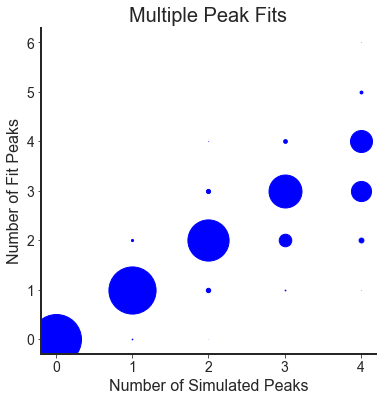

In [19]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_peaks_bubbles(n_peak_counter, save_fig=SAVE_FIG)

#### Aperiodic Components

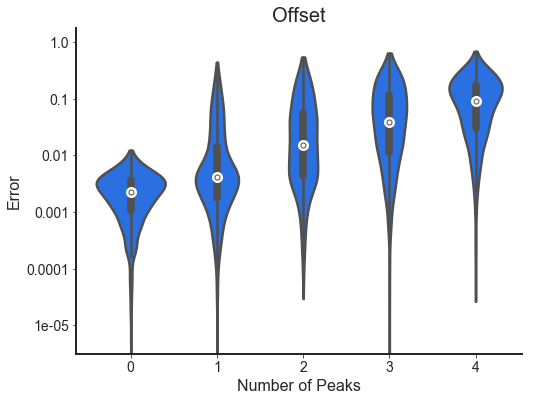

In [20]:
# Multi-peak fitting: plot error of aperiodic offset reconstruction across number of peaks
plot_errors_violin(off_errors, 'Offset',
                   x_axis='n_peaks', plt_log=True, ylim=[-5.5, 0.25])

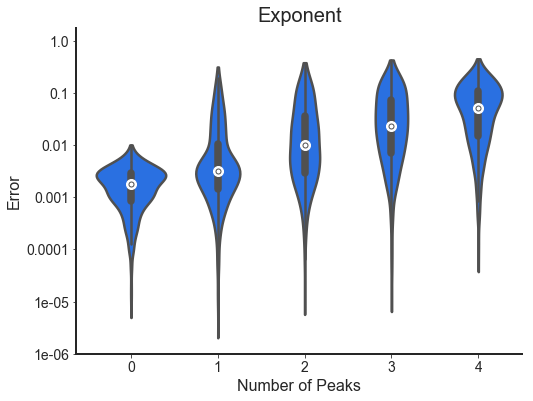

In [21]:
# Multi-peak fitting: plot error of aperiodic exponent reconstruction across number of peaks
plot_errors_violin(exp_errors, 'Exponent',
                   x_axis='n_peaks', plt_log=True, ylim=[-6, 0.25])

#### Goodness of Fit Measures

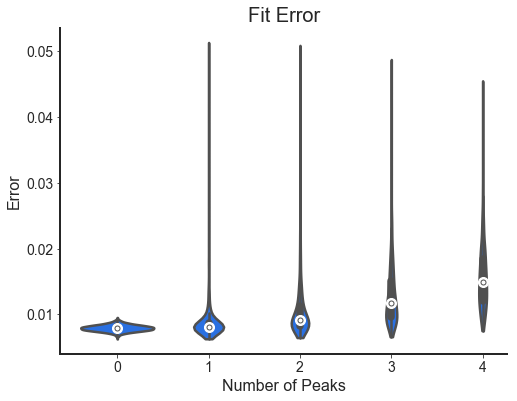

In [22]:
# Multi-peak fitting: plot error levels across number of peaks
plot_errors_violin(err_fits, 'Fit Error',
                   x_axis='n_peaks', plt_log=False,
                   save_fig=SAVE_FIG, save_name='MPeak-Err')

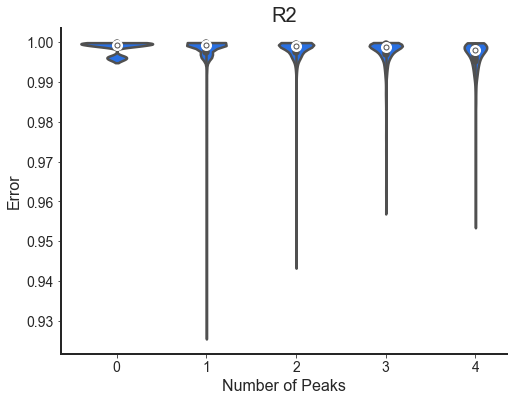

In [23]:
# Multi-peak fitting: plot R^2 levels across number of peaks
plot_errors_violin(r2_fits, 'R2', x_axis='n_peaks', plt_log=False)

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 2.0], gaussian_params=[[5, 0.25, 1.0], [15, 0.4, 2.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0442, 2.0282                                          
                                                                                                  
            

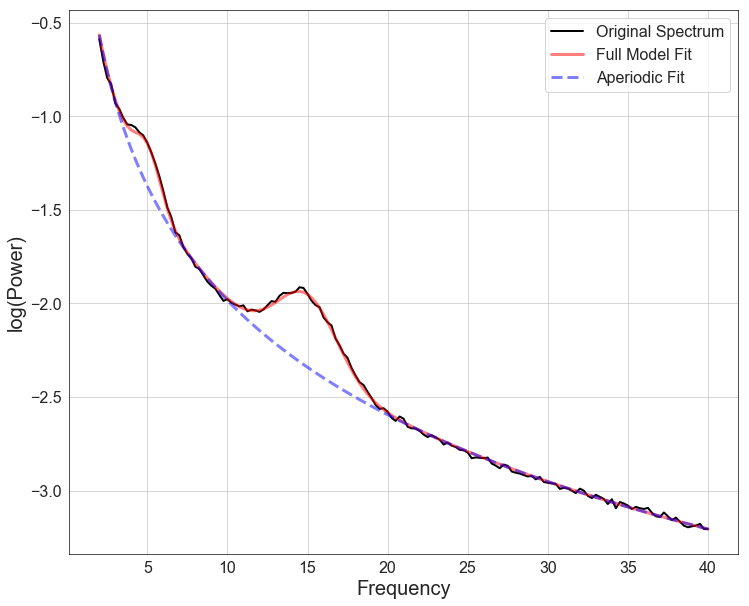

In [24]:
# Grab example case, plot & save out
ind = 1
fm = fgs[2].get_fooof(ind, True)
print(sim_params[2][ind])
fm.print_results()
fm.plot(save_fig=SAVE_FIG, file_path=FIGS_PATH, file_name='MultiPeak-2P')

SimParams(aperiodic_params=[0, 0.5], gaussian_params=[[9, 0.2, 1.0], [16, 0.15, 3.0], [24, 0.2, 2.0], [27, 0.25, 1.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0137, 0.5047                                          
                                                                              

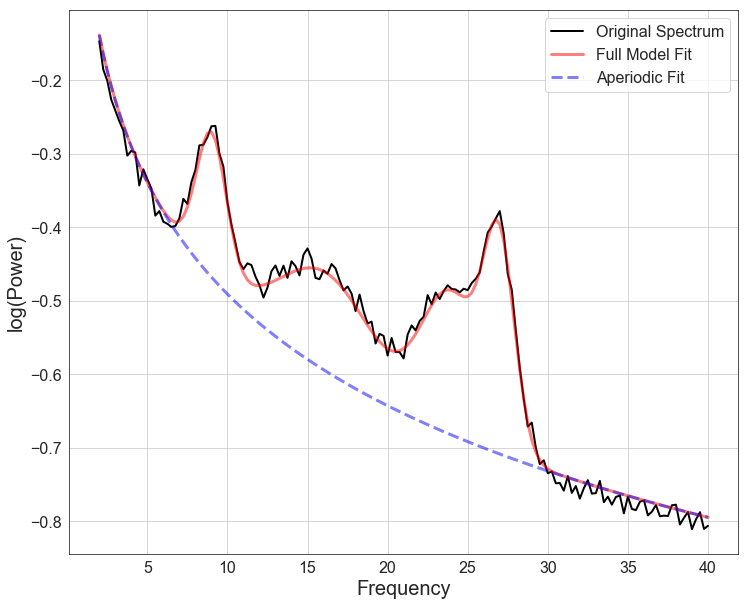

In [27]:
# Grab example case, plot & save out
ind = 25
fm = fgs[-1].get_fooof(ind, True)
print(sim_params[-1][ind])
fm.print_results()
fm.plot(save_fig=SAVE_FIG, file_path=FIGS_PATH, file_name='MultiPeak-4P')